# Cluster Analysis
**Date**: 300924

In [3]:
#!pip install seaborn

In [4]:
# Importación de librerías
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [9]:
# Cargar datos
df = pd.read_csv('wine-clustering.csv')

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [10]:
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Varianza explicada por componente: [0.36198848 0.1920749 ]


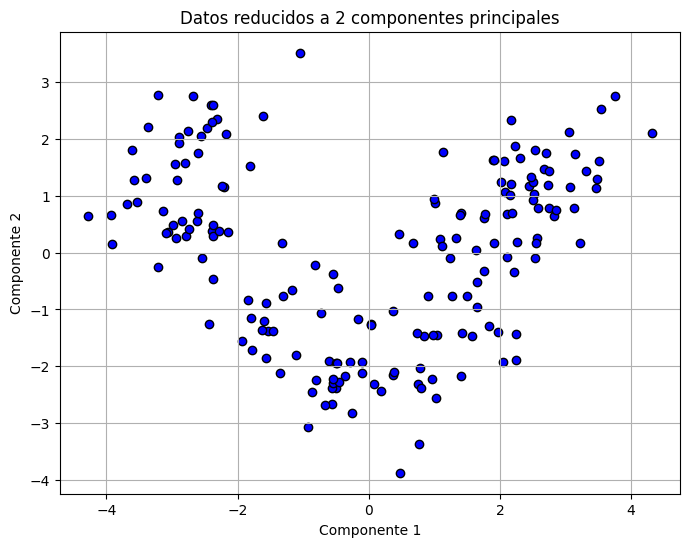

In [11]:
# Aplicar PCA para reducción de dimensionalidad
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar la varianza explicada
explained_variance = pca.explained_variance_ratio_
print(f'Varianza explicada por componente: {explained_variance}')

# Visualización en 2D
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', marker='o', edgecolor='k')
plt.title('Datos reducidos a 2 componentes principales')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid()
plt.show()


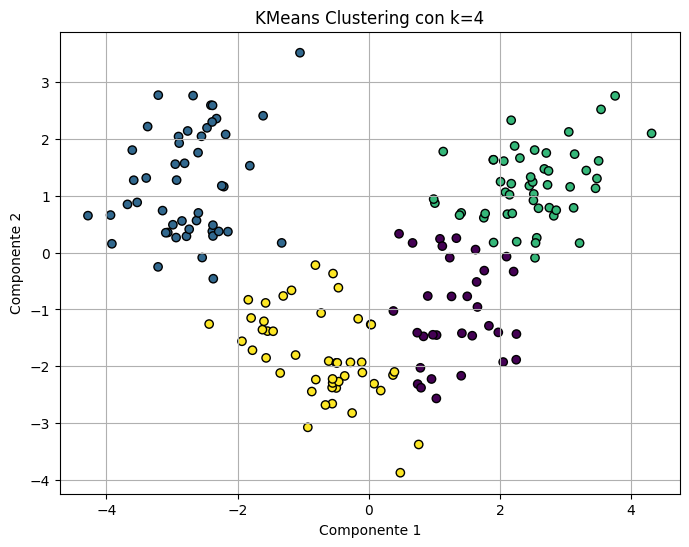

In [22]:
# KMeans con búsqueda de mejor k
kmeans = KMeans(random_state=42)
params = {'n_clusters': range(2, 5)}
grid_kmeans = GridSearchCV(kmeans, param_grid=params, cv=3)
grid_kmeans.fit(X_pca)

# Predicciones y evaluación
best_kmeans = grid_kmeans.best_estimator_
y_kmeans = best_kmeans.predict(X_pca)

# Visualización KMeans
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', marker='o', edgecolor='k')
plt.title(f'KMeans Clustering con k={best_kmeans.n_clusters}')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid()
plt.show()


In [25]:
from sklearn.metrics import silhouette_score, make_scorer
import numpy as np

# Definir un Silhouette Scorer que funcione sólo si hay más de 1 cluster
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    
    # Verificar si hay más de 1 cluster
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        # Retornar un puntaje negativo para modelos con un solo cluster
        return -1

# Crear el scorer para GridSearchCV
silhouette_scorer = make_scorer(silhouette_scorer)


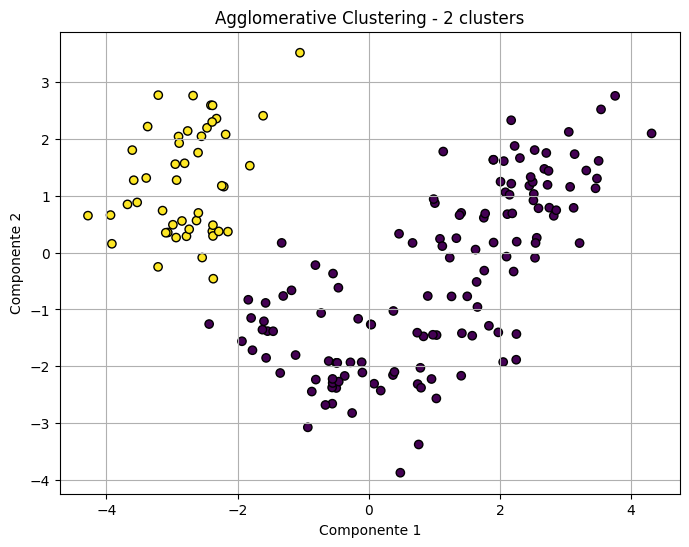

Mejor configuración: {'n_clusters': 2}


In [33]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# Crear un Scorer personalizado para Agglomerative Clustering
class ClusteringScorer:
    def __call__(self, estimator, X):
        labels = estimator.fit_predict(X)
        
        # Verificar si hay más de un cluster
        if len(set(labels)) > 1 and len(set(labels)) < len(X):
            return silhouette_score(X, labels)
        else:
            return -1  # Retornar -1 si solo hay un cluster

# Instanciar el scorer
clustering_scorer = ClusteringScorer()

# Definir los parámetros para Agglomerative Clustering
agg_clust = AgglomerativeClustering()
params = {'n_clusters': range(2, 6)}  # Ajustar el rango de clusters que quieres explorar

# Usar GridSearchCV con el scorer personalizado
grid_agg = GridSearchCV(agg_clust, param_grid=params, scoring=clustering_scorer, cv=3)
grid_agg.fit(X_pca)  # Usar X_pca o X_scaled según el caso

# Obtener el mejor modelo y predicciones
best_agg = grid_agg.best_estimator_
y_agg = best_agg.fit_predict(X_pca)

# Contar el número de clusters
n_clusters = len(set(y_agg))

# Visualizar los resultados
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_agg, cmap='viridis', marker='o', edgecolor='k')
plt.title(f'Agglomerative Clustering - {n_clusters} clusters')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid()
plt.show()

# Evaluación del mejor modelo
print(f'Mejor configuración: {grid_agg.best_params_}')


In [35]:
# Métricas de evaluación
def evaluate_clustering(X, labels):
    silhouette_avg = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Index: {davies_bouldin}')
    
# Evaluación para KMeans
print('Evaluación KMeans:')
evaluate_clustering(X_pca, y_kmeans)

print('-----------------------------------------')

# Evaluación para Agglomerative Clustering
print('Evaluación Agglomerative Clustering:')
evaluate_clustering(X_pca, y_agg)


Evaluación KMeans:
Silhouette Score: 0.4914213395710316
Davies-Bouldin Index: 0.7422307067719098
-----------------------------------------
Evaluación Agglomerative Clustering:
Silhouette Score: 0.47359230795635215
Davies-Bouldin Index: 0.7315395921249306


# Interpretación del Silhouette Score:
Su rango es de -1 a 1:
- 1: Los clusters están bien definidos y separados.
- 0: Los clusters están superpuestos o muy cercanos.
- Valores negativos: Muchos puntos están asignados al cluster incorrecto.

# Interpretación del Davies-Bouldin Index:
Toma valores mayores o iguales a 0:
- Valores más cercanos a 0 indican una mejor formación de clusters (bien separados y con baja dispersión interna).
- No hay un límite superior, pero valores más altos (por ejemplo, por encima de 2 o 3) sugieren clusters mal definidos.